In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import numpy as np
import pandas as pd

# Universal ODEs

## One More Step

**Is it really worth it?**

So far, we have just used gradient descent to train ODEs

* We could have achieved the same results with other methods
* What is the added value of using a "neural" engine?

**There are several advantages**

High-dimensionality is not a problem

* We can train ODEs with multiple parameters
* E.g. $V_s$ or $\tau$ that vary over time

We can approximate ODEs with weaker methods

* We managed to use Euler method to obtain good curves
* ...And weaker methods are computationally cheaper

## Universal Ordinary Differential Equations

**The real deal is the ability to incorporate black-box functions**

This is sometimes called a [Universal Ordinary Differential Equation](https://arxiv.org/abs/2001.04385) (UDE)

$$
\dot{y} = f(y, t, U(y, t))
$$

* $y$, $t$, and $f$ are as usual
* ...Except that some of its parameters come from a second function $U$
* $U$ is a trainable universal approximator (typically a NN)

**This is an example of neuro-symbolic integration**

* $f$ encodes (interpretable) knowledge about the system behavior
* $U$ can be trained to learn implicit knowledge from data

The result is a simple, but very flexible, hybrid framework

## An Example

**As ax example, let's consider the SIR model we have encountered**

This is a simple, but locally effective, epidemic model

$$\begin{align}
\dot{S} & = - \beta \frac{1}{N} SI \\
\dot{I} & = + \beta \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

**Say we want to control the epidemic via Non-Pharmaceutical Interventions**

* E.g. using masks, social distancing, etc.
* These typically have an effect on $\beta$, and they change over time

They can (partially) explain multiple waves observed in a real epidemic

## SIR with NPIs

**We can model the effect of NPIs via a UDE model**

$$\begin{align}
\dot{S} & = - \beta(t) \frac{1}{N} SI \\
\dot{I} & = + \beta(t) \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

* Where $U(y, t)$ corresponds to $\beta(t)$

In practice, depending on $t$ certain NPIs will be active and affect $\beta$

* The connection is complex and cannot be modeled by an expert
* ...But given enough data, it could be learned

**Let's see the idea in action on a use case**

## Use Case Parameters

**We will consider a synthetic use case**

...For simplicity and to have access to ground truth information

* We will assume that initially $1\%$ of the population is infected
* ...That the recovery time is 10 days ($\gamma = 1/10$)
* ...And that the "natural" $\beta$ value is 0.3

In [2]:
S0, I0, R0 = 0.99, 0.01, 0.00
beta_base, gamma = 0.3, 1/10

**We assume that NPIs cut that number by a measure-specific _factor_**

Assuming $I$ is the set of active NPIs, the ground truth function $\hat{\beta}(t)$ is:

$$
\hat{\beta}(t) = \beta \prod_{i \in I} e_i
$$

## Non-Pharmaceutical Interventions

**We will consider the following NPIs**

In [5]:
npis = [
    util.NPI('masks-indoor', effect=0.75, cost=1),
    util.NPI('masks-outdoor', effect=0.9, cost=1),
    util.NPI('dad', effect=0.7, cost=3),
    util.NPI('bar-rest', effect=0.6, cost=3),
    util.NPI('transport', effect=0.6, cost=4)
]

For sake of simplicity, we will sample NPI values at random

* We will change them at random every week
* ...Update the $\beta(t)$ value accordingly
* And simulate the epidemics by integrating a SIR model
* ...Using an accurate method

## The Dataset

**Let's use this approach of build a 52-week dataset**

In [6]:
nweeks = 52
data = util.gen_SIR_NPI_dataset(S0, I0, R0, beta_base, gamma, npis, nweeks, steps_per_day=5, seed=42)
data.iloc[:8]

,S,I,R,week,masks-indoor,masks-outdoor,dad,bar-rest,transport,beta
0.0,0.990000,0.010000,0.000000,0,0,0,1,1,0,0.126
1.0,0.988738,0.010250,0.001012,0,0,0,1,1,0,0.126
2.0,0.987446,0.010504,0.002050,0,0,0,1,1,0,0.126
3.0,0.986124,0.010763,0.003113,0,0,0,1,1,0,0.126
4.0,0.984771,0.011026,0.004203,0,0,0,1,1,0,0.126
5.0,0.983388,0.011294,0.005319,0,0,0,1,1,0,0.126
6.0,0.981972,0.011566,0.006462,0,0,0,1,1,0,0.126
7.0,0.980525,0.011843,0.007632,1,1,0,0,1,1,0.081


* Despite the results are obtained using an accurate method
* ...We still assume access to a single measurement per day

**This is typically the case in real-world epidemics**

## The Dataset

**Let's plot the $S, I, R$ component from the dataset**

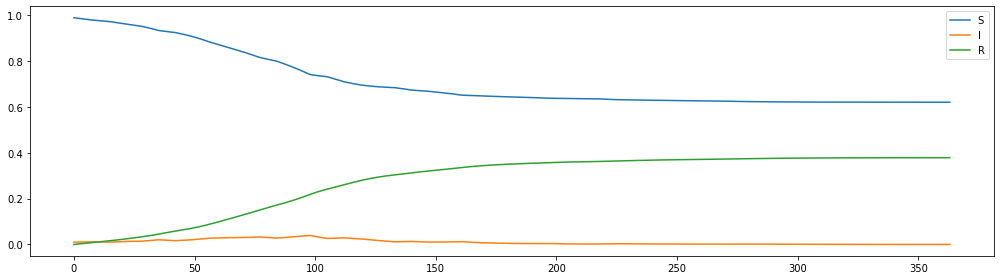

In [7]:
util.plot_df_cols(data[['S', 'I', 'R']], figsize=figsize)

* There is still a single wave
* ...Due to how we sampled the NPIs (and their effects)

## The Dataset

**Locally, the behavior is more complex**

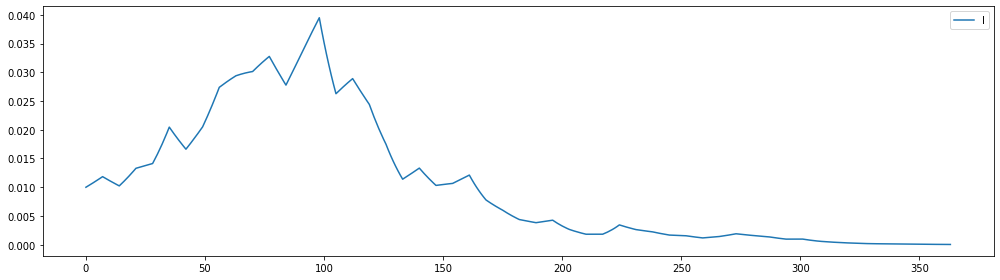

In [8]:
util.plot_df_cols(data[['I']], figsize=figsize)

* When $\frac{\hat{\beta}(t)}{\gamma} > 1$ we have a true epidemic behavior
* When $\frac{\hat{\beta}(t)}{\gamma} \leq 1$, the number of new cases always drops

## The Implementation

**In principle, our previous code should be enough**

...I.e. we could use a custom layer for the UDE:

$$\begin{align}
\dot{S} & = - \beta(t) \frac{1}{N} SI \\
\dot{I} & = + \beta(t) \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

In practice, things are slightly more complicated

* Formally, the input for $\beta(t)$ is _time_
* ...But the input we care about are the _active NPIs_

## The Implementation

**Therefore, a more accurate formulation would be**

$$\begin{align}
\dot{S} & = - \beta(\mathit{NPI}(t)) \frac{1}{N} SI \\
\dot{I} & = + \beta(\mathit{NPI}(t)) \frac{1}{N} SI - \gamma I \\
\dot{R} & = + \gamma I
\end{align}$$

In principle, our custom layer should:

* Take as input $S, I, R$ and $t$
* Use $t$ to retrieve $NPI(t)$
* ...And then compute the gradient

**In practice, it's easier to supply the NPIs as additional inputs**

## Custom NPI-SIR Layer

**We provide the SIR layer with a $\beta(\mathit{NPI})$ model at construction time**

```python
class NPISIRNablaLayer(keras.layers.Layer):
    def __init__(self, beta_pred, gamma_ref=0.1, fixed_gamma=None):
        ...
        self.beta_pred = beta_pred # NPI-to-beta model
        ...

    def call(self, inputs):
        y, t, npis = inputs # unpack
        ...
        beta = self.beta_pred(npis) # obtain beta
        ...
```

* This is the `beta_pred` parameter in the `NPISIRNablaLayer` class
* In the `call` method we unpack the auxiliary input

## Custom NPI-SIR Layer

**We provide the SIR layer with a $\beta(\mathit{NPI})$ model at construction time**

```python
class NPISIRNablaLayer(keras.layers.Layer):
    def __init__(self, beta_pred, gamma_ref=0.1, fixed_gamma=None):
        ...
        self.beta_pred = beta_pred # NPI-to-beta model
        ...

    def call(self, inputs):
        y, t, npis = inputs # unpack
        ...
        beta = self.beta_pred(npis) # obtain beta
        ...
```

* `npis` is a vector representing active NPI, using a 0/1 encoding
* ...And we use the `beta_pred` model to obtain $\beta$

## Modified Euler Method Model

**Then, we modify our custom model**

We introduce a _flag_ to tell the model we plan to use auxiliary inputs


```python
class ODEEulerModel(keras.Model):
    def __init__(self, f, auxiliary_input=False, **params):
        ...

    def call(self, inputs, training=False):
        if self.auxiliary_input:
            y, T, aux = inputs
        else:
            y, T = inputs
        ...
```

* We unpack all inputs in the `call`,  `train_step`, and `test_step` method
* We have the initial state `y`, the evaluation points `T`, and `aux`

## Modified Euler Method Model

**Then, we modify our custom model**

We introduce a _flag_ to tell the model we plan to use auxiliary inputs


```python
class ODEEulerModel(keras.Model):
    def __init__(self, f, auxiliary_input=False, **params):
        ...

    def call(self, inputs, training=False):
        if self.auxiliary_input:
            y, T, aux = inputs
        else:
            y, T = inputs
        ...
```

* We need an NPI vector for each evaluation point (except the last)
* Hence `aux` should have `len(T)-1` elements

## Preparing the Training Data

**The data structures for the initial state are as usual**

In [9]:
tr_y0 = data[['S', 'I', 'R']].values[:-1];
print(tr_y0[:2])

[[0.99       0.01       0.        ]
 [0.98873788 0.01024967 0.00101245]]


The same goes for the evaluation points

In [10]:
euler_steps = 5
tr_T = np.linspace(data.index[:-1], data.index[1:], euler_steps).T
print(tr_T[:2])

[[0.   0.25 0.5  0.75 1.  ]
 [1.   1.25 1.5  1.75 2.  ]]


* We choose to use 5 euler steps per time unit, for a better approximation
* Since our goal is estimating $\beta$, accuracy is important

## Preparing the Training Data

**NPI vectors stay constant for every time unit**

In [11]:
npi_names = [n.name for n in npis]
tmp = data[npi_names].values[:-1]
ns = len(tr_y0)
tr_npi = np.tile(tmp, euler_steps-1).reshape(ns, -1, len(npi_names))
print(tr_npi[:2])

[[[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]]

 [[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]]]


* We obtain the NPI values for each time unit
* ...And we repeat them for every intermediate Euler step
* Since NPIs are input, they are not needed for the last step

## Preparing the Training Data

**The target data is as usual**

In [12]:
ns = len(tr_y0)
tr_y = np.full((ns, euler_steps, 3), np.nan)
tr_y[:, -1, :] = data[['S', 'I', 'R']].values[1:]
print(tr_y[:2])

[[[       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.98873788 0.01024967 0.00101245]]

 [[       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [       nan        nan        nan]
  [0.98744604 0.01050389 0.00205007]]]


* Most entries are null, since we have only one measurement per time unit

## Building the Model

**We start by building the $\beta(\mathit{NPI})$ model**

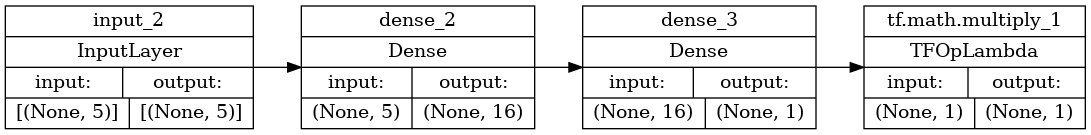

In [14]:
beta_pred = util.build_ml_model(input_size=len(npi_names), output_size=1,
                               hidden=[16], output_activation='exponential', scale=0.1)
util.plot_ml_model(beta_pred)

* We use an exponential activation to ensure non-negative $\beta$ values
* ...And a scaling factor to make the initial guess more reasonable

Then we build an instance of the modified SIR layer and feed it to the Euler model:

In [15]:
dSIR = util.NPISIRNablaLayer(beta_pred=beta_pred, fixed_gamma=gamma)
euler = util.ODEEulerModel(dSIR, auxiliary_input=True)

## Training

**Now we can perform training as usual**

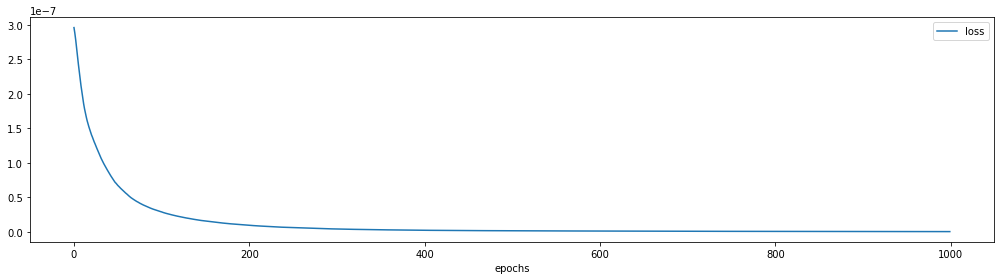

Model loss: 0.0000 (training)
CPU times: user 18.5 s, sys: 2.87 s, total: 21.4 s
Wall time: 11.2 s


In [16]:
%%time
history = util.train_ml_model(euler, [tr_y0, tr_T, tr_npi], tr_y, validation_split=0.0, epochs=1000)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**Let's the the quality of estimate curves**

We will use the `call` method to have the same conditions as training

* We prepare the initial state

In [17]:
run_y0 = data[['S', 'I', 'R']].iloc[0].values
run_y0 = np.array([run_y0])
print(run_y0)

[[0.99 0.01 0.  ]]


* Then all the evaluation points (in a whole year)

In [18]:
run_T = np.arange(0, data.index[-1]+1/euler_steps, 1/euler_steps)
run_T = np.array([run_T])
print(run_T)

[[0.000e+00 2.000e-01 4.000e-01 ... 3.626e+02 3.628e+02 3.630e+02]]


## Evaluation

**Let's the the quality of estimate curves**

Finally, we prepare the NPI vectors

In [19]:
run_npis = np.tile(data[npi_names].values, euler_steps).reshape(-1, len(npi_names))
run_npis = np.array([run_npis])
print(run_npis)

[[[0 0 1 1 0]
  [0 0 1 1 0]
  [0 0 1 1 0]
  ...
  [1 1 1 0 1]
  [1 1 1 0 1]
  [1 1 1 0 1]]]


...And finally we integrate the ODE

In [20]:
run_y = euler([run_y0, run_T, run_npis])

## Evaluation

**Let's plot the original measurement and the estimated curve**

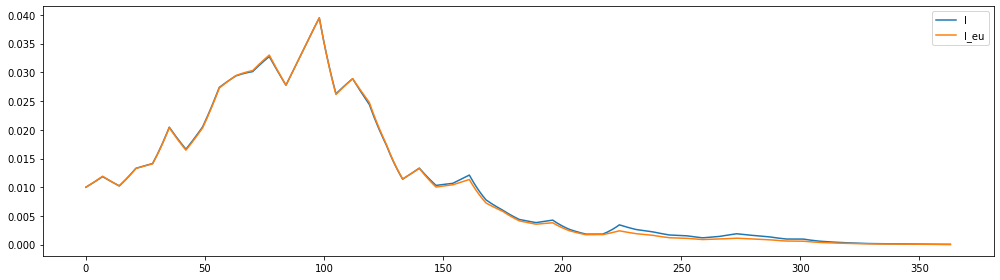

In [21]:
run_cmp = pd.DataFrame(data=run_y[0].numpy(), index=run_T[0], columns=['S_eu', 'I_eu', 'R_eu'])
run_cmp[['S', 'I', 'R']] = data[['S', 'I', 'R']]
run_cmp[['S', 'I', 'R']] = run_cmp[['S', 'I', 'R']].interpolate()
util.plot_df_cols(run_cmp[['I', 'I_eu']], figsize=figsize)

* There is a pretty good match

## Beta Estimation

**Finally, let's make a qualitative check of our $\beta$ estimates**

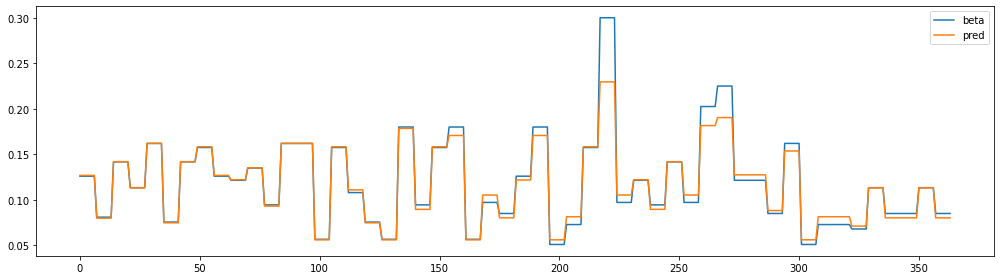

In [22]:
beta_cmp = data[['beta']].copy()
beta_cmp['pred'] = beta_pred.predict(data[npi_names])
util.plot_df_cols(beta_cmp, figsize=figsize)

* The estimates are quite good, except for the later part of the sequence
* This is due mostly to our choosing the plain MSE as a loss function

## Final Considerations

**Keep in mind that this example has limitations**

* In practice, a SIR model may not be the best match
* The NPIs actually tested may cover the input space poorly
* Some state component may not be measurable (e.g. $S$)

But the UDE approach is very flexible and can be quite effective

**What is the connection with constraints?**

* A simple approach to account for constraints in ML
* ...Is to enforce them at an architectural level

UDEs are one interesting case of this more general template